In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from pysb.examples.earm_1_0 import model
from scipy.stats import wasserstein_distance, energy_distance, ks_2samp
from scipy.interpolate import splrep, sproot

In [2]:
from obj_functions import compare_avgs, momp_distance, extract_momp

In [3]:
# proteins in EARM model
genes = [
    'BAX', 'BCL2', 'BID', 'CYCS', 'FADD',
    'CASP3', 'CASP8', 'CASP9', 'CASP6',
    'CFLAR', #FLIP
    'XIAP', 
    'DIABLO', #SMAC
    'TNFRSF10A', #DR4
    'TNFRSF10B', #DR5
    'PARP1',
    'APAF1', 
    'BFAR', #BAR
        ]

in_both = {
    'A549',
    'AN3-CA',
    'CAPAN-2',
    'Daudi',
    'EFO-21',
    'HDLM-2',
    'HEL',
    'HL-60',
    'HeLa',
    'K-562',
    'MCF7',
    'MOLT-4',
    'PC-3',
    'REH',
    'RPMI-8226',
    'RT4',
    'SK-MEL-30',
    'SiHa',
    'THP-1',
    'WM-115'
}

In [4]:
data_path = os.path.join('data', 'EC-RP_IMS-RP_IC-RP_data_for_models.csv')

exp_data = pd.read_csv(data_path, index_col=False)
print(exp_data.head(5))
momp_data = np.array([9810.0, 180.0, model.parameters['mSmac_0'].value])
momp_var = np.array([7245000.0, 3600.0, 1e4])

   Time   IC-RP  norm_IC-RP  nrm_var_IC-RP  IMS-RP  IMS-RP step  VAR   EC-RP  \
0   180  0.7063         0.0         0.0006     0.0          0.0  1.0  0.4451   
1   360  0.7063         0.0         0.0006     0.0          0.0  1.0  0.4460   
2   540  0.7063         0.0         0.0006     0.0          0.0  1.0  0.4459   
3   720  0.7063         0.0         0.0006     0.0          0.0  1.0  0.4458   
4   900  0.7063         0.0         0.0006     0.0          0.0  1.0  0.4474   

   norm_EC-RP  nrm_var_EC-RP  
0      0.0020         0.0003  
1      0.0018         0.0003  
2      0.0015         0.0003  
3      0.0051         0.0003  
4      0.0038         0.0002  


In [5]:
def plot(f_name, image_name):
    if not os.path.exists(f_name):
#         print("Traj doesn't exist")
        return None
    traj = pd.read_csv(f_name)
    
    traj_dist = traj.copy()
    traj_dist.reset_index(inplace=True)
    traj_dist.time /= 3600
    t = traj_dist.time.unique()
    tspan = t
    def calc_tod(traj):
        """ Calculates time of death of PARP trajectory

        Assumes PARP is 90% cleaved, if not returns nans.

        Parameters
        ----------
        traj : pd.Dataframe

        Returns
        -------
        time_of_switch : np.float
        """

        momp_traj = traj['cSmac_total'].values
        momp_sim = _fit_spline(momp_traj)
        td = momp_sim[0]
        return td


    def _fit_spline(momp_traj):
        ysim_momp_norm = momp_traj / np.nanmax(momp_traj)
        st, sc, sk = splrep(tspan, ysim_momp_norm)
        try:
            t10 = sproot((st, sc - 0.10, sk))[0]
            t90 = sproot((st, sc - 0.90, sk))[0]
        except IndexError:
            t10 = 0
            t90 = 0

        # time of death  = halfway point between 10 and 90%
        td = (t10 + t90) / 2

        # time of switch is time between 90 and 10 %
        ts = t90 - t10
        return [td, ts, momp_traj[-1]]
    
    def extract_momp(traj_dist):
        tds = []
        for sim, df in traj_dist.groupby('simulation'):
            tds.append(calc_tod(df))
        return np.array(tds)
    tods = extract_momp(traj_dist)

    verbose = False
    if verbose:
        print("New cost function score: {}".format(compare_avgs(traj)))
        print("Old cost function score: {}".format(momp_distance(traj)))

    
    norm = {
        'tBid_total' : model.parameters['Bid_0'].value,
        'CPARP_total' : model.parameters['PARP_0'].value,
        'cSmac_total' : model.parameters['mSmac_0'].value,
    }    
    
    def add_plot(observable):
        traj_copy = traj_dist.copy()
        
        traj_copy[observable] = traj_copy[observable]#/norm[observable]
        
        traj = pd.pivot_table(
            traj_copy, values=observable, index='time',
            columns='simulation'
        ).values

        plt.plot(t, traj, '0.5', lw=2, alpha=0.25)
        plt.plot(t, traj[:, 0].T, '0.5', lw=2, alpha=0.25,
                label='individual simulations')

        sns.lineplot(
            x="time",
            y=observable,
            label='mean',
            data=traj_copy,
        )
        plt.legend(loc=0)
#         plt.ylim(-.1, 1.1)
    
    # create individual traces
    plt.figure(figsize=(6, 4))
    
#     plt.subplot(231)
#     add_plot('tBid_total')    
#     plt.subplot(232)
#     add_plot('cSmac_total')
#     plt.subplot(111)
    add_plot('CPARP_total')
    
    plt.tight_layout()
   
    plt.savefig(image_name, bbox_inches='tight')
    return tods

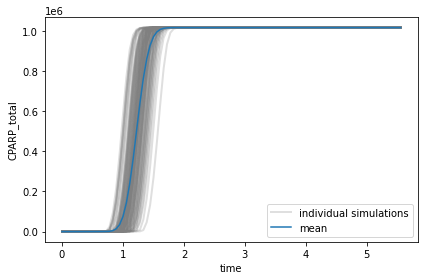

In [6]:
tod_a549 = plot('traj/A549.csv', 'A549')

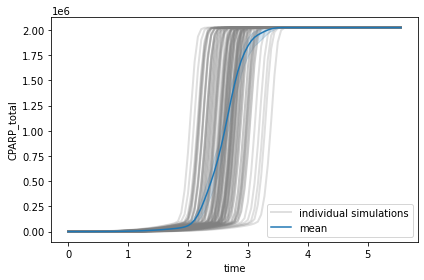

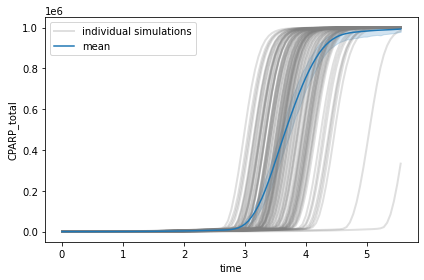

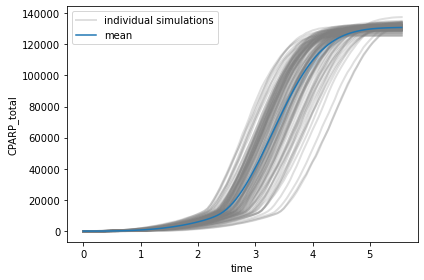

In [7]:
tod_AN3_CA = plot('traj/AN3_CA.csv', 'AN3_CA')
tod_HeLa = plot('traj/HeLa.csv', 'HeLa')
tod_EFO_21 = plot('traj/EFO_21.csv', 'EFO_21')

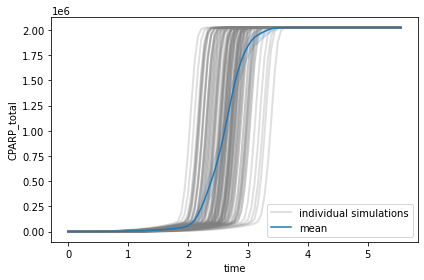

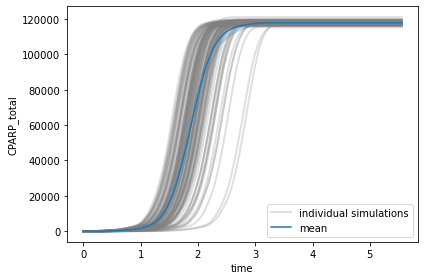

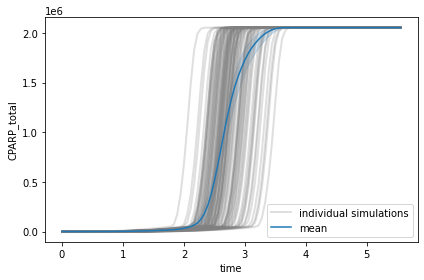

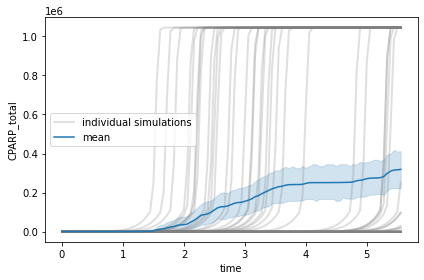

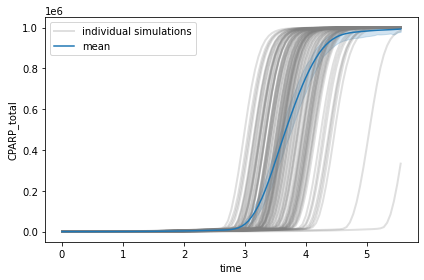

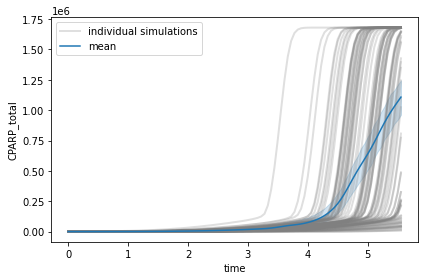

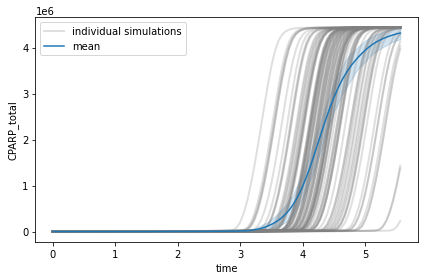

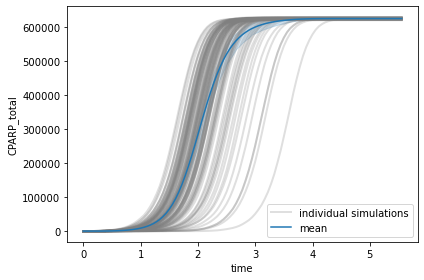

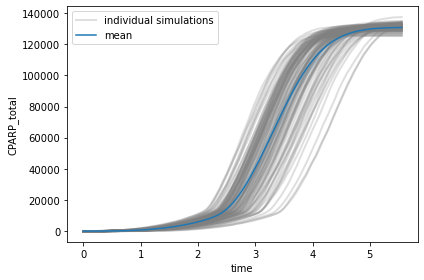

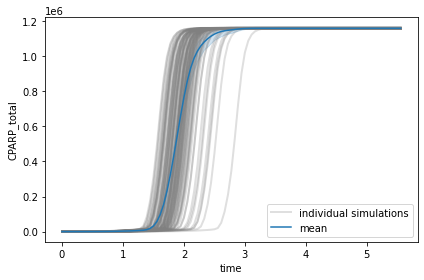

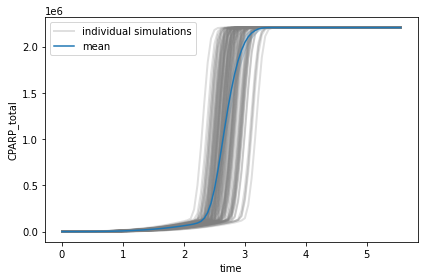

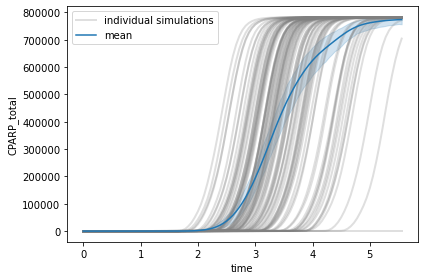

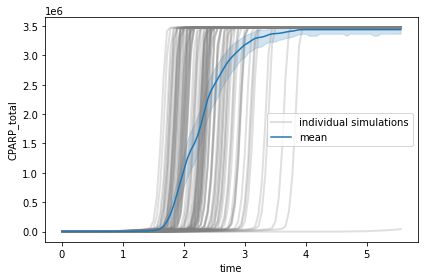

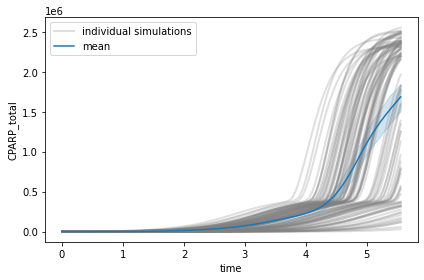

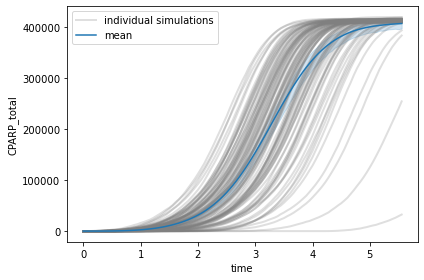

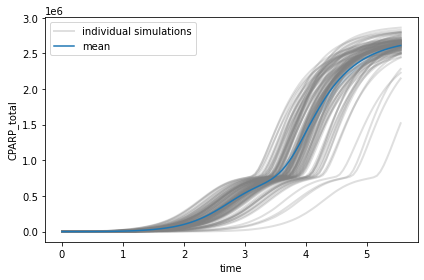

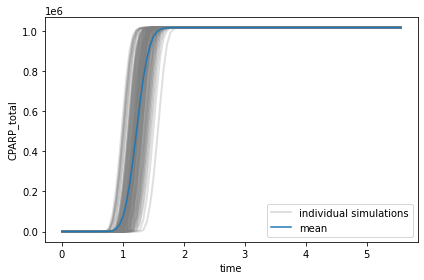

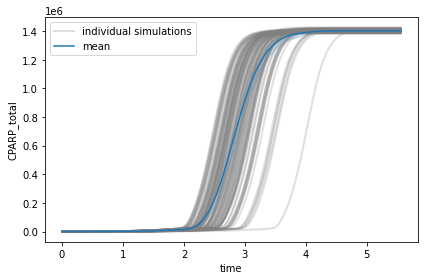

In [8]:
tod_per_cell_line = dict()
for i in in_both:
    name = i.replace('-', '_')
    tod_per_cell_line[name] = plot(f'traj/{name}.csv', name)
    

AN3_CA 2.4220241779901004
CAPAN_2 1.2928865080783694
PC_3 2.46036164375336
MOLT_4 1.1063527765020786
HeLa 3.3483708297231014
THP_1 4.186665106013441
Daudi 3.8483249563696926
HDLM_2 4.688305137190237
EFO_21 2.5886806970389777
RT4 1.59812482236404
WM_115 2.4761886485417803
MCF7 2.657707168825509
K_562 2.155315716786614
HL_60 4.144996743002043
RPMI_8226 0.5463980962242484
REH 3.632554039158904
A549 0.9572849446249299
SiHa 2.3199022973581394


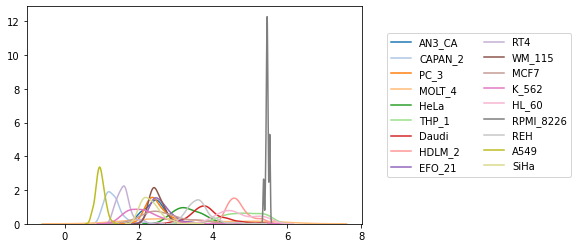

In [9]:
sns.set_palette("tab20")
plt.figure(figsize=(6, 4))
for i,j in tod_per_cell_line.items():
    if j is None:
        continue
    print(i, j.mean())
    sns.distplot(
        j,
        kde=True,
        hist=False,
#         color='red',
        kde_kws=dict(clip=(0, 8),),
        label=i
    )
plt.legend(loc="upper center", bbox_to_anchor=(1.35, .9), ncol=2);

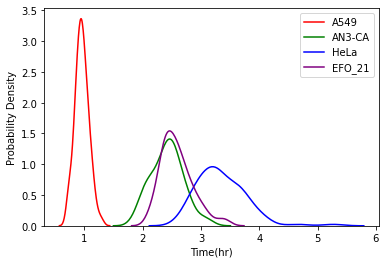

In [10]:
sns.distplot(
    tod_a549,
    kde=True,
    hist=False,
    color='red',
    kde_kws=dict(clip=(0, 8),),
    label='A549'
)
sns.distplot(
    tod_AN3_CA,
    kde=True,
    hist=False,
    color='green',
    kde_kws=dict(clip=(0, 8),),
    label='AN3-CA'
)
sns.distplot(
    tod_HeLa,
    kde=True,
    hist=False,
    color='blue',
    kde_kws=dict(clip=(0, 8),),
    label='HeLa'
)
sns.distplot(
    tod_EFO_21,
    kde=True,
    hist=False,
    color='purple',
    kde_kws=dict(clip=(0, 8),),
    label='EFO_21'
)
plt.xlabel("Time(hr)")
plt.ylabel("Probability Density")
plt.savefig("cell_line_tod.png", dpi=300, bbox_inches='tight')